In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, StratifiedGroupKFold
import shap
import gpplot as gpp
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings
from core import tssbin_binary
from lightgbm import LGBMRegressor, plot_importance
from core1 import (setup_plots,
                  lollipop_plot,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.WARNING)


Todo
- DHS
- each nuetitde as a single nts only
- gilbert et al: top 5 features, look at easy feature


In [2]:
#Function
def obs_vals_vs_scores(dataset, list_obs_vals, list_scores, author='Gilbert', obs_meteric = 'Gamma'):
    for obs_v, score in zip(list_obs_vals, list_scores):
            plt.subplots(figsize=(4,4))
            gpp.point_densityplot(data=dataset[[score, obs_v]].dropna(),
                                     y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                   y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                    y=score, x=obs_v, method='spearman', loc='lower right')
           # plt.xlabel(x_axis_name)
            plt.title(author+" Crispri")
            plt.xlabel(obs_meteric)
           
            sns.despine()
            gpp.savefig('../figure/dhs/'+ score +'_vs_'+obs_meteric+'_'+author+'.pdf', dpi=300)
def tss_plot(dataset, y_axis, dataname='gilbert'):
    x_orders = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                            '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                             '+225 to +250','>+250']
    fig, axs = plt.subplots(nrows=len(y_axis),figsize=(7,6))
    for i in range(len(y_axis)):
        ax = sns.boxplot(data=dataset, x="tss_bins", y=y_axis[i], 
                   order = x_orders, color = 'grey', ax = axs[i])
        if i != len(y_axis)-1:
            ax.set(xticklabels=[])  
            ax.set(xlabel=None)
            ax.tick_params(bottom=False)
        else:
            ax.set(xlabel='TSS Bins')
            plt.xticks(rotation=90)
    
    gpp.savefig('../figure/dhs/'+ dataname +'_tss_box_plot.pdf', dpi=300)
def corr_pval_table(dataset, metric):
    tss_bins_cat = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                        '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                         '+225 to +250','>+250']
    data_performance = pd.DataFrame()
    for bins in tss_bins_cat:
        bin_sub = dataset[dataset['tss_bins'] == bins]
        corr_rs3, p_corr_rs3 = stats.spearmanr(bin_sub['Chen On-Target Efficacy Score'], bin_sub[str('avg_' + metric)])
        #corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['reverse ' + metric])
        corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['avg_' + metric])

        data_performance = data_performance.append({'bin':bins,
                                          'corr_rs3': corr_rs3, 
                                          'p_val_corr_rs3': p_corr_rs3,
                                          'corr_seq_target': corr_target,
                                         'p_val_corr_seq_target': p_corr_target}, ignore_index=True)
    return data_performance

# Train model

### Import Gilbert to train 

In [3]:
gilbert2014_rs3 = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)


In [4]:
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_gamma', 'avg_mean_centered_neg_gamma','DHS Score']]
gilbert2014_rs3 = tssbin_binary(gilbert2014_rs3)

In [5]:
tss_bins_col_name = [col for col in gilbert2014_rs3.columns if col.startswith('tss_bins_')]
x_variable = ['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence','Chen On-Target Efficacy Score','DHS Score'] + tss_bins_col_name

### Define X and Y and group in gilbert 

In [6]:
X = gilbert2014_rs3[x_variable]
X = X.set_index('sgRNA Context Sequence')    
y = gilbert2014_rs3['avg_gamma'] * -1
grps = gilbert2014_rs3['Target Gene Symbol']


### Define objective to train the model on Gilbert

In [9]:
def objective(trial, X, y, groups, cv=4 ):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01,0.02,0.03,0.04, 0.05]),
        "num_leaves": trial.suggest_int('num_leaves', 8, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 256)

    }

    cv_scores = np.zeros(cv)
    
    #gkf_cv = GroupKFold(n_splits=3)
    gkf_cv = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=1)
    df_group = pd.DataFrame()


    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X,[1]*grps, groups=groups)):
        X_train, X_test, y_train, y_test = X.iloc[ix_train], X.iloc[ix_test], y.iloc[ix_train], y.iloc[ix_test]

        model = LGBMRegressor(random_state=7, n_jobs=1, **param_grid)
        df_group = df_group.append({'fold': split, 'num_train_gene': len(set(grps[ix_train].tolist())),
                    'num_train_sgrna': len(grps[ix_train].tolist()), 
                    'num_test_gene': len(set(grps[ix_test].tolist())),
                   'num_test_sgRNA': len(grps[ix_test].tolist()),
                   'num_overlap_gene': len(list(set(grps[ix_train]) & set(grps[ix_test])))}, ignore_index=True)
        print(df_group)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            verbose=-1,
             early_stopping_rounds=50,)
        preds = model.score(X_train, y_train)
        
        cv_scores[split] = preds


    return 1-np.mean(cv_scores)

In [10]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

def func(trial):
    return objective(trial, X, y, grps)

study.optimize(func, n_trials=50);

[I 2022-11-10 03:19:33,306] A new study created in memory with name: LGBM Regressor


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l2: 0.0116458
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	valid_0's l2: 0.0120014
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:19:35,007] Trial 0 finished with value: 0.8163962481156486 and parameters: {'n_estimators': 1212, 'learning_rate': 0.02, 'num_leaves': 239, 'min_child_samples': 208}. Best is trial 0 with value: 0.8163962481156486.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 0.0116577
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0120758
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:19:36,646] Trial 1 finished with value: 0.7861250320665034 and parameters: {'n_estimators': 241, 'learning_rate': 0.02, 'num_leaves': 66, 'min_child_samples': 53}. Best is trial 1 with value: 0.7861250320665034.


Early stopping, best iteration is:
[90]	valid_0's l2: 0.0123183
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's l2: 0.0116533
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.01199
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:19:37,864] Trial 2 finished with value: 0.8197492530630308 and parameters: {'n_estimators': 1157, 'learning_rate': 0.05, 'num_leaves': 120, 'min_child_samples': 252}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's l2: 0.0116283
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0120087
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:19:39,590] Trial 3 finished with value: 0.8102705372092922 and parameters: {'n_estimators': 1183, 'learning_rate': 0.02, 'num_leaves': 133, 'min_child_samples': 172}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 0.0116281
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0119712
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:19:41,046] Trial 4 finished with value: 0.8162165497379306 and parameters: {'n_estimators': 1166, 'learning_rate': 0.03, 'num_leaves': 134, 'min_child_samples': 219}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0116345
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0120334
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:19:42,305] Trial 5 finished with value: 0.8069053465062089 and parameters: {'n_estimators': 1216, 'learning_rate': 0.04, 'num_leaves': 167, 'min_child_samples': 107}. Best is trial 1 with value: 0.7861250320665034.


Early stopping, best iteration is:
[57]	valid_0's l2: 0.0122311
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's l2: 0.0116253
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's l2: 0.0119716
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:19:43,686] Trial 6 finished with value: 0.8172005934734121 and parameters: {'n_estimators': 1455, 'learning_rate': 0.03, 'num_leaves': 220, 'min_child_samples': 228}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's l2: 0.0122586
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[141]	valid_0's l2: 0.0117077
   fold  num_train_gene  num_train_sgrna  num_test_gen

[I 2022-11-10 03:19:44,927] Trial 7 finished with value: 0.8435227498372297 and parameters: {'n_estimators': 141, 'learning_rate': 0.01, 'num_leaves': 135, 'min_child_samples': 234}. Best is trial 1 with value: 0.7861250320665034.


Did not meet early stopping. Best iteration is:
[141]	valid_0's l2: 0.0123929
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 0.0116465
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0120363
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945            

[I 2022-11-10 03:19:46,165] Trial 8 finished with value: 0.8135086124390571 and parameters: {'n_estimators': 1191, 'learning_rate': 0.04, 'num_leaves': 115, 'min_child_samples': 152}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0122287
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0116124
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:19:47,270] Trial 9 finished with value: 0.8113886025863903 and parameters: {'n_estimators': 446, 'learning_rate': 0.04, 'num_leaves': 20, 'min_child_samples': 98}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0122034
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0116223
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:19:48,707] Trial 10 finished with value: 0.7934153854283374 and parameters: {'n_estimators': 630, 'learning_rate': 0.02, 'num_leaves': 41, 'min_child_samples': 54}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0122896
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's l2: 0.011607
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:19:50,088] Trial 11 finished with value: 0.8033559240241623 and parameters: {'n_estimators': 629, 'learning_rate': 0.02, 'num_leaves': 27, 'min_child_samples': 63}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 0.0122628
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's l2: 0.0116517
   fold  num_train_gene  num_train_sgrna  num_test_gene

[I 2022-11-10 03:19:51,384] Trial 12 finished with value: 0.7889570615851306 and parameters: {'n_estimators': 109, 'learning_rate': 0.02, 'num_leaves': 66, 'min_child_samples': 54}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0123336
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 0.0116228
   fold  num_train_gene  num_train_sgrna  n

[I 2022-11-10 03:19:52,699] Trial 13 finished with value: 0.8040953435019207 and parameters: {'n_estimators': 104, 'learning_rate': 0.02, 'num_leaves': 71, 'min_child_samples': 88}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0116182
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0120281
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:19:53,854] Trial 14 finished with value: 0.8091697383291702 and parameters: {'n_estimators': 325, 'learning_rate': 0.05, 'num_leaves': 79, 'min_child_samples': 125}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0122153
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's l2: 0.0116561
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:19:56,418] Trial 15 finished with value: 0.7955072357734866 and parameters: {'n_estimators': 353, 'learning_rate': 0.01, 'num_leaves': 71, 'min_child_samples': 77}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's l2: 0.011627
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 0.0120149
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:19:57,884] Trial 16 finished with value: 0.8107169687902063 and parameters: {'n_estimators': 873, 'learning_rate': 0.02, 'num_leaves': 92, 'min_child_samples': 127}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0116208
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0120608
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:19:59,252] Trial 17 finished with value: 0.794075641196471 and parameters: {'n_estimators': 205, 'learning_rate': 0.02, 'num_leaves': 48, 'min_child_samples': 52}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 0.0122967
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's l2: 0.0116332
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:20:00,818] Trial 18 finished with value: 0.8138591772513768 and parameters: {'n_estimators': 533, 'learning_rate': 0.02, 'num_leaves': 158, 'min_child_samples': 164}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0116352
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.0120273
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:20:02,039] Trial 19 finished with value: 0.8010432759728856 and parameters: {'n_estimators': 814, 'learning_rate': 0.03, 'num_leaves': 53, 'min_child_samples': 77}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 0.0122721
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's l2: 0.0116836
   fold  num_train_gene  num_train_sgrna  num_test_gene

[I 2022-11-10 03:20:03,330] Trial 20 finished with value: 0.8336365455174259 and parameters: {'n_estimators': 290, 'learning_rate': 0.01, 'num_leaves': 8, 'min_child_samples': 119}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's l2: 0.0122672
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0116049
   fold  num_train_gene  num_train_sgrna  num_test_gen

[I 2022-11-10 03:20:04,690] Trial 21 finished with value: 0.7919130899652147 and parameters: {'n_estimators': 504, 'learning_rate': 0.02, 'num_leaves': 44, 'min_child_samples': 52}. Best is trial 1 with value: 0.7861250320665034.


Early stopping, best iteration is:
[107]	valid_0's l2: 0.0122845
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 0.0116409
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 0.0120433
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:20:06,337] Trial 22 finished with value: 0.7913840111676671 and parameters: {'n_estimators': 444, 'learning_rate': 0.02, 'num_leaves': 102, 'min_child_samples': 73}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's l2: 0.0116513
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 0.0120643
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:20:07,940] Trial 23 finished with value: 0.7932556129137256 and parameters: {'n_estimators': 215, 'learning_rate': 0.02, 'num_leaves': 101, 'min_child_samples': 71}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's l2: 0.0116419
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.012037
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:20:09,584] Trial 24 finished with value: 0.8008754893057983 and parameters: {'n_estimators': 370, 'learning_rate': 0.02, 'num_leaves': 93, 'min_child_samples': 87}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0116325
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0120373
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:20:10,780] Trial 25 finished with value: 0.8059566369249072 and parameters: {'n_estimators': 668, 'learning_rate': 0.05, 'num_leaves': 60, 'min_child_samples': 104}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0122456
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0116587
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:20:12,697] Trial 26 finished with value: 0.8087272988867313 and parameters: {'n_estimators': 240, 'learning_rate': 0.02, 'num_leaves': 163, 'min_child_samples': 143}. Best is trial 1 with value: 0.7861250320665034.


Early stopping, best iteration is:
[144]	valid_0's l2: 0.0122176
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's l2: 0.0116652
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0120505
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:20:14,602] Trial 27 finished with value: 0.7902865476610357 and parameters: {'n_estimators': 444, 'learning_rate': 0.02, 'num_leaves': 113, 'min_child_samples': 67}. Best is trial 1 with value: 0.7861250320665034.


Early stopping, best iteration is:
[95]	valid_0's l2: 0.0123468
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's l2: 0.0116241
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's l2: 0.0120277
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945            

[I 2022-11-10 03:20:16,433] Trial 28 finished with value: 0.799458561142592 and parameters: {'n_estimators': 150, 'learning_rate': 0.02, 'num_leaves': 184, 'min_child_samples': 92}. Best is trial 1 with value: 0.7861250320665034.


Did not meet early stopping. Best iteration is:
[115]	valid_0's l2: 0.0122644
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 0.0116549
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's l2: 0.0119947
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945          

[I 2022-11-10 03:20:18,225] Trial 29 finished with value: 0.8167380724522723 and parameters: {'n_estimators': 940, 'learning_rate': 0.02, 'num_leaves': 226, 'min_child_samples': 192}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 0.0116702
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l2: 0.0120577
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:21,289] Trial 30 finished with value: 0.7901255003217874 and parameters: {'n_estimators': 429, 'learning_rate': 0.01, 'num_leaves': 79, 'min_child_samples': 66}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's l2: 0.0116786
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 0.0120569
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:24,157] Trial 31 finished with value: 0.7889606952837475 and parameters: {'n_estimators': 400, 'learning_rate': 0.01, 'num_leaves': 71, 'min_child_samples': 63}. Best is trial 1 with value: 0.7861250320665034.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's l2: 0.0116548
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's l2: 0.0120993
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:27,215] Trial 32 finished with value: 0.7777891868058355 and parameters: {'n_estimators': 277, 'learning_rate': 0.01, 'num_leaves': 85, 'min_child_samples': 50}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's l2: 0.0115929
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's l2: 0.0120432
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:29,572] Trial 33 finished with value: 0.7991034659146762 and parameters: {'n_estimators': 279, 'learning_rate': 0.01, 'num_leaves': 33, 'min_child_samples': 53}. Best is trial 32 with value: 0.7777891868058355.


Did not meet early stopping. Best iteration is:
[273]	valid_0's l2: 0.0122796
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0117817
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0121522
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1

[I 2022-11-10 03:20:31,145] Trial 34 finished with value: 0.8387297148993557 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 64, 'min_child_samples': 83}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[179]	valid_0's l2: 0.0116923
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's l2: 0.0120636
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2   

[I 2022-11-10 03:20:33,807] Trial 35 finished with value: 0.7947505483824329 and parameters: {'n_estimators': 196, 'learning_rate': 0.01, 'num_leaves': 85, 'min_child_samples': 65}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's l2: 0.01163
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's l2: 0.012022
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:20:36,455] Trial 36 finished with value: 0.8092246705864891 and parameters: {'n_estimators': 357, 'learning_rate': 0.01, 'num_leaves': 125, 'min_child_samples': 114}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0116723
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 0.0120632
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:20:37,569] Trial 37 finished with value: 0.7928472803828023 and parameters: {'n_estimators': 1011, 'learning_rate': 0.05, 'num_leaves': 61, 'min_child_samples': 60}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 0.0123344
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0116482
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:20:38,869] Trial 38 finished with value: 0.814460201992111 and parameters: {'n_estimators': 534, 'learning_rate': 0.03, 'num_leaves': 146, 'min_child_samples': 186}. Best is trial 32 with value: 0.7777891868058355.


Early stopping, best iteration is:
[102]	valid_0's l2: 0.0122302
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's l2: 0.0116497
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 0.0119867
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:20:40,125] Trial 39 finished with value: 0.8182085001008967 and parameters: {'n_estimators': 266, 'learning_rate': 0.04, 'num_leaves': 106, 'min_child_samples': 254}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's l2: 0.0116156
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 0.0120203
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:42,619] Trial 40 finished with value: 0.8009820360867163 and parameters: {'n_estimators': 1314, 'learning_rate': 0.01, 'num_leaves': 249, 'min_child_samples': 97}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's l2: 0.011668
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's l2: 0.0120854
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:20:45,017] Trial 41 finished with value: 0.7817385037027493 and parameters: {'n_estimators': 418, 'learning_rate': 0.01, 'num_leaves': 73, 'min_child_samples': 50}. Best is trial 32 with value: 0.7777891868058355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's l2: 0.0116561
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0121014
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:20:47,616] Trial 42 finished with value: 0.7760388038412072 and parameters: {'n_estimators': 685, 'learning_rate': 0.01, 'num_leaves': 88, 'min_child_samples': 50}. Best is trial 42 with value: 0.7760388038412072.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	valid_0's l2: 0.011614
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	valid_0's l2: 0.0120624
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:20:49,507] Trial 43 finished with value: 0.7974431806872302 and parameters: {'n_estimators': 609, 'learning_rate': 0.01, 'num_leaves': 36, 'min_child_samples': 55}. Best is trial 42 with value: 0.7760388038412072.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l2: 0.0116458
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's l2: 0.012036
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:20:52,017] Trial 44 finished with value: 0.796756878805847 and parameters: {'n_estimators': 744, 'learning_rate': 0.01, 'num_leaves': 94, 'min_child_samples': 81}. Best is trial 42 with value: 0.7760388038412072.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0116648
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0121082
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:20:53,192] Trial 45 finished with value: 0.7871527819322913 and parameters: {'n_estimators': 160, 'learning_rate': 0.04, 'num_leaves': 81, 'min_child_samples': 51}. Best is trial 42 with value: 0.7760388038412072.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0123565
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0116672
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:20:54,415] Trial 46 finished with value: 0.794258177418164 and parameters: {'n_estimators': 311, 'learning_rate': 0.04, 'num_leaves': 122, 'min_child_samples': 74}. Best is trial 42 with value: 0.7760388038412072.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0123269
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0116708
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0120959
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:20:55,653] Trial 47 finished with value: 0.778474374749343 and parameters: {'n_estimators': 1078, 'learning_rate': 0.04, 'num_leaves': 83, 'min_child_samples': 50}. Best is trial 42 with value: 0.7760388038412072.


Early stopping, best iteration is:
[50]	valid_0's l2: 0.0123705
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's l2: 0.011658
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's l2: 0.0119735
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:20:56,896] Trial 48 finished with value: 0.8166713154272572 and parameters: {'n_estimators': 1276, 'learning_rate': 0.04, 'num_leaves': 52, 'min_child_samples': 242}. Best is trial 42 with value: 0.7760388038412072.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0122431
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.011688
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0120586
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315         

[I 2022-11-10 03:20:58,108] Trial 49 finished with value: 0.787683982817931 and parameters: {'n_estimators': 1052, 'learning_rate': 0.04, 'num_leaves': 137, 'min_child_samples': 64}. Best is trial 42 with value: 0.7760388038412072.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0123512


In [11]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.77604
	Best params:
		n_estimators: 685
		learning_rate: 0.01
		num_leaves: 88
		min_child_samples: 50


In [12]:
model = LGBMRegressor( **study.best_params)
model.fit(X, y)

LGBMRegressor(learning_rate=0.01, min_child_samples=50, n_estimators=685,
              num_leaves=88)

In [13]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
# explainer_model = shap.Explainer(model)
shap_values_model = explainer(X)
#gpp.savefig('../figure/shapval_model_seq_tss_v2.pdf', dpi=300)

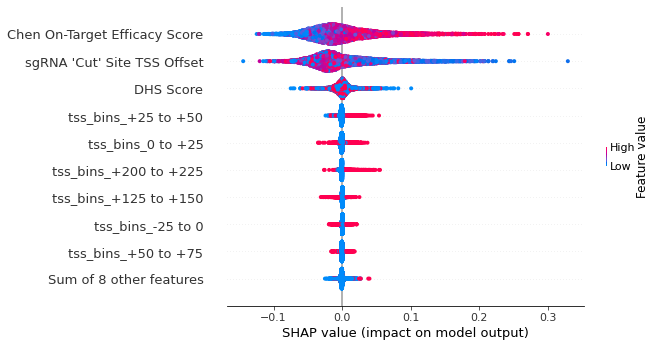

In [26]:
shap.plots.beeswarm(shap_values_model)


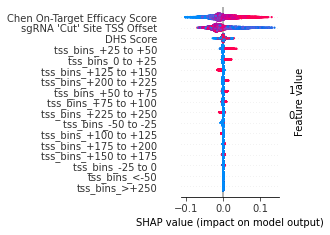

In [14]:
summary_legacy(shap_values_model, X, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=50)
gpp.savefig('../figure/dhs/shapval_model_seq_tss.pdf', dpi=300)

# Check the most optimal prediction using Gilbert

In [15]:
X_gilbert = X
y_gilbert = y

In [16]:
X_gilbert['Crispri Seq + Target Score'] = model.predict(X_gilbert)
X_gilbert.reset_index(inplace=True)

In [17]:
X_val_pre_y_gilbert = pd.merge(gilbert2014_rs3, X_gilbert, 
                               on = list(set(gilbert2014_rs3.columns) & set(X_gilbert.columns)))

In [18]:
#X_val_pre_y_gilbert['reverse gamma'] = X_val_pre_y_gilbert['avg_gamma']*-1

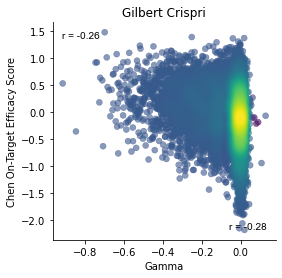

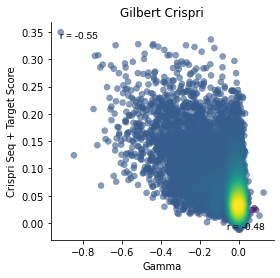

In [19]:
#obs_vals = [ 'avg_gamma', 'reverse gamma']
obs_vals = [ 'avg_gamma', 'avg_gamma']
scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_gilbert, obs_vals, scores, author='Gilbert', obs_meteric = 'Gamma')

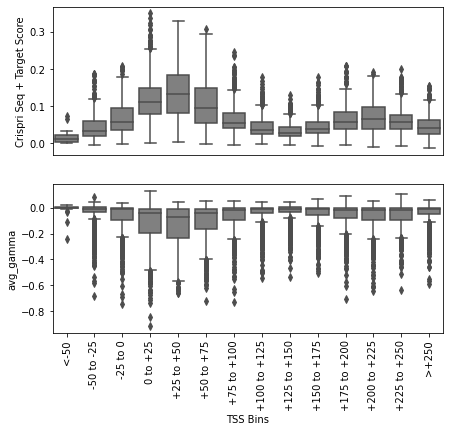

In [20]:
y_axis_gilbert = ["Crispri Seq + Target Score", 'avg_gamma']
tss_plot(X_val_pre_y_gilbert,y_axis_gilbert)

In [21]:
gilbert_performance = corr_pval_table(X_val_pre_y_gilbert, metric = 'gamma')

In [22]:
gilbert_performance

,bin,corr_rs3,p_val_corr_rs3,corr_seq_target,p_val_corr_seq_target
0,<-50,-0.356719,9.475101e-02,-0.134387,5.409738e-01
1,-50 to -25,-0.223628,8.775065e-10,-0.321787,3.614316e-19
2,-25 to 0,-0.236031,3.668072e-12,-0.392041,1.973267e-32
3,0 to +25,-0.268912,9.070488e-19,-0.476133,3.062949e-60
4,+25 to +50,-0.380375,4.365975e-32,-0.539725,1.408105e-68
5,+50 to +75,-0.377657,2.879616e-33,-0.527438,1.665124e-68
6,+75 to +100,-0.282004,1.275281e-16,-0.447542,4.486973e-42
7,+100 to +125,-0.252137,1.325435e-13,-0.369861,1.573304e-28
8,+125 to +150,-0.184255,6.874567e-08,-0.296920,1.165575e-18
9,+150 to +175,-0.255465,7.064837e-14,-0.378842,8.020420e-30


In [23]:
corr_gilbert = pd.melt(gilbert_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

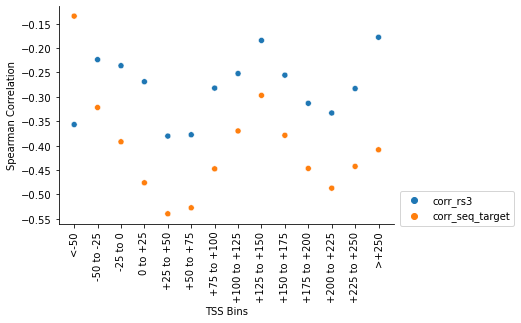

In [24]:
sns.scatterplot(data=corr_gilbert, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/dhs/gilbert_spearman_tss_box_plot.pdf', dpi=300)


# Test on Horlbeck 2016_sept

In [25]:
test_dataset_horlbeck = pd.read_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')


#### Add TSS bins binary

In [26]:
test_dataset_horlbeck = test_dataset_horlbeck.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_horlbeck = tssbin_binary(test_dataset_horlbeck)

#### Define X and Y 

In [27]:
test_dataset_horlbeck_X = test_dataset_horlbeck[x_variable]
test_dataset_horlbeck_X = test_dataset_horlbeck_X.set_index('sgRNA Context Sequence')    
y = test_dataset_horlbeck['avg_lfc'] *-1

#### Predicted

In [28]:
test_dataset_horlbeck_X['Crispri Seq + Target Score'] = model.predict(test_dataset_horlbeck_X)
test_dataset_horlbeck_X.reset_index(inplace=True)

In [29]:
X_val_pre_y_horlbeck = pd.merge(test_dataset_horlbeck, test_dataset_horlbeck_X, 
                       on = list(set(test_dataset_horlbeck.columns) & set(test_dataset_horlbeck_X.columns)))

In [30]:

#X_val_pre_y_horlbeck['reverse lfc'] = X_val_pre_y_horlbeck['avg_lfc']*-1

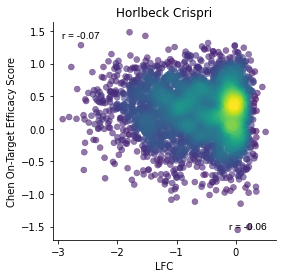

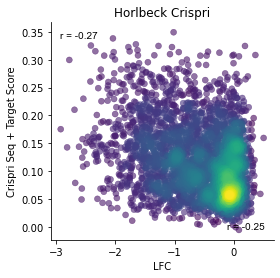

In [31]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_horlbeck, obs_vals_h, scores, author='Horlbeck', obs_meteric = 'LFC')

In [50]:
X_val_pre_y_horlbeck['tss_bins'].value_counts()

+25 to +50      645
0 to +25        599
+50 to +75      499
-25 to 0        285
+75 to +100     209
+200 to +225    178
+225 to +250    171
>+250           153
+175 to +200    126
-50 to -25       94
+150 to +175     91
+100 to +125     83
+125 to +150     50
<-50              3
Name: tss_bins, dtype: int64

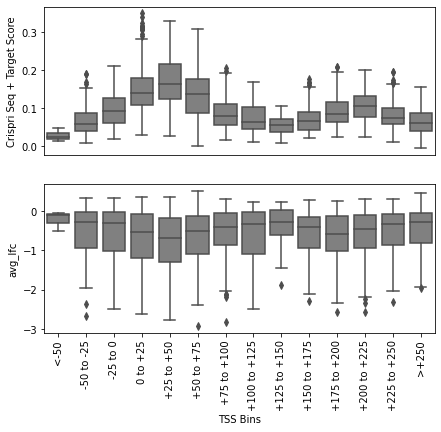

In [32]:
y_axis_horlbeck = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_horlbeck,y_axis_horlbeck, dataname='horlbeck')

In [33]:
horlbeck_performance = corr_pval_table(X_val_pre_y_horlbeck, metric = 'lfc')
corr_horlbeck = pd.melt(horlbeck_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

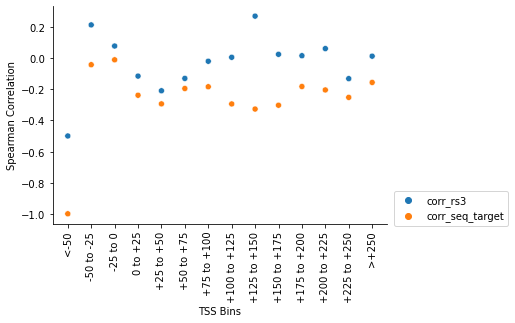

In [34]:
sns.scatterplot(data=corr_horlbeck, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/dhs/horlbeck_spearman_tss_box_plot.pdf', dpi=300)


# Sanson et al

In [35]:
test_dataset_sanson = pd.read_csv('../data/sanson_2018/sanson2018_activity.csv')


In [36]:
test_dataset_sanson = test_dataset_sanson.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_sanson= tssbin_binary(test_dataset_sanson)

In [37]:
sum(test_dataset_sanson['sgRNA \'Cut\' Site TSS Offset'] <= -50)

0

In [38]:
test_dataset_sanson['tss_bins_<-50'] = 0

In [39]:
test_dataset_sanson_X = test_dataset_sanson[x_variable]
test_dataset_sanson_X = test_dataset_sanson_X.set_index('sgRNA Context Sequence')    
y = test_dataset_sanson['avg_lfc']*-1

In [40]:
test_dataset_sanson_X['Crispri Seq + Target Score'] = model.predict(test_dataset_sanson_X)
test_dataset_sanson_X.reset_index(inplace=True)

In [41]:
X_val_pre_y_sanson = pd.merge(test_dataset_sanson, test_dataset_sanson_X, 
                              on = list(set(test_dataset_sanson.columns) & set(test_dataset_sanson_X.columns)))

In [42]:
#X_val_pre_y_sanson['reverse lfc'] = X_val_pre_y_sanson['avg_lfc']*-1

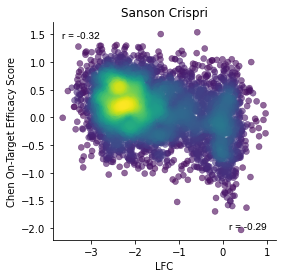

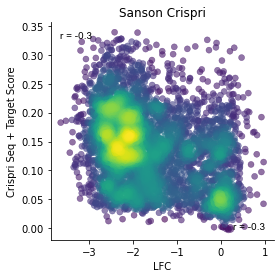

In [43]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_sanson, obs_vals_h, scores, author='Sanson', obs_meteric = 'LFC')

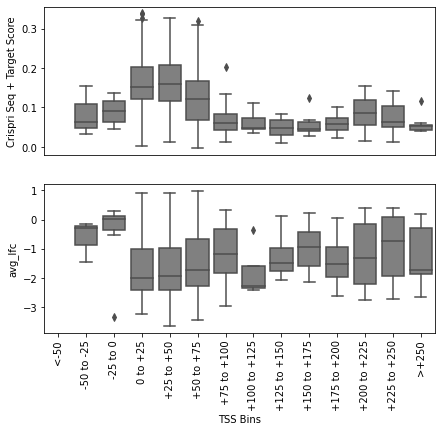

In [44]:
y_axis_sanson = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_sanson,y_axis_sanson, dataname = 'sanson')

In [45]:
sanson_performance = corr_pval_table(X_val_pre_y_sanson, metric = 'lfc')
corr_sanson = pd.melt(sanson_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

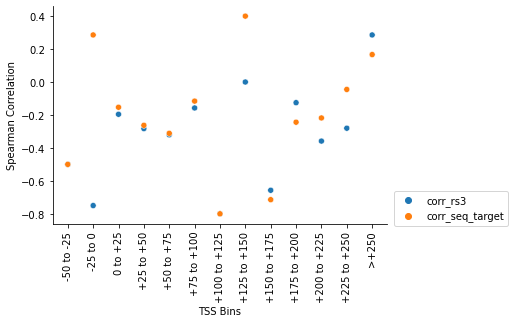

In [46]:
sns.scatterplot(data=corr_sanson, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/dhs/sanson_spearman_tss_box_plot.pdf', dpi=300)


In [64]:
# anaysis

In [116]:
gene_symbol = pd.DataFrame(X_val_pre_y_sanson['Target Gene Symbol'].value_counts()).reset_index()
gene_symbol = gene_symbol[gene_symbol['Target Gene Symbol'] >= 3]
gene_3 = X_val_pre_y_sanson[X_val_pre_y_sanson['Target Gene Symbol'].isin(gene_symbol['index'])]

In [117]:
gene_corr_rs3 = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Chen On-Target Efficacy Score']].corr(method = 'spearman').unstack()
gene_corr_rs3.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3 = pd.DataFrame(gene_corr_rs3.iloc[:,1]).reset_index()

In [118]:
gene_corr_rs3_target = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_rs3_target.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3_target = pd.DataFrame(gene_corr_rs3_target.iloc[:,1]).reset_index()

In [119]:
gene_corr_scores = gene_3.groupby('Target Gene Symbol')[['Chen On-Target Efficacy Score','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_scores.columns = ['Correlation_Val1_Val1', 'Correlation_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_scores = pd.DataFrame(gene_corr_scores.iloc[:,1]).reset_index()


In [120]:
gene_corr = pd.merge(pd.merge(gene_corr_rs3, gene_corr_rs3_target, on = 'Target Gene Symbol'), gene_corr_scores, on = 'Target Gene Symbol')

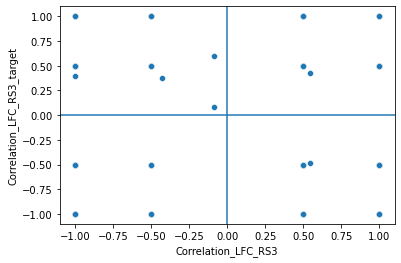

In [127]:
sns.scatterplot(data=gene_corr, x="Correlation_LFC_RS3", y="Correlation_LFC_RS3_target")
plt.axvline(0, 0,2)
plt.axhline(0, 0,2)

<AxesSubplot:xlabel='Correlation_RS3_target'>

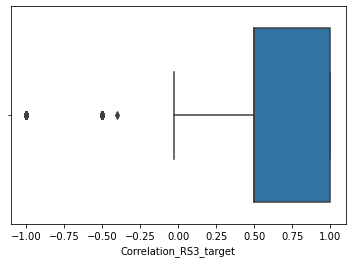

In [122]:
sns.boxplot(x=gene_corr["Correlation_RS3_target"] )

In [136]:
gene_corr[(gene_corr['Correlation_LFC_RS3'] < 0) & (gene_corr['Correlation_LFC_RS3_target']>0)]

,Target Gene Symbol,Correlation_LFC_RS3,Correlation_LFC_RS3_target,Correlation_RS3_target
1,AARS1,-0.5,0.5,0.5
5,ABCB7,-0.5,0.5,0.5
13,ACTR10,-0.5,0.5,-1.0
14,ACTR1A,-0.5,0.5,-1.0
23,ALDOA,-0.5,0.5,0.5
...,...,...,...,...
1391,ZBTB11,-1.0,0.5,-0.5
1392,ZBTB17,-0.5,0.5,0.5
1393,ZC3H18,-0.5,0.5,0.5
1403,ZNF408,-1.0,0.5,-0.5
